In [117]:
import pandas as pd, numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.linear_model import LassoCV, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.feature_selection import SelectFromModel, VarianceThreshold
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import cross_val_score
from sklearn.ensemble import RandomForestRegressor

### Import the data

In [118]:
test= pd.read_csv('../assets/new_test.csv')

In [119]:
with open('../assets/X.pkl', 'rb') as f:
    X= pickle.load(f)

In [120]:
with open('../assets/y.pkl', 'rb') as f:
    y= pickle.load(f)

### Train test split

Since the dataset is time series data, I need to use time series split because days might be correlated to each other. 

In [121]:
ts= TimeSeriesSplit(3)

In [122]:
for train_index, test_index in ts.split(X):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

#### Scale the data

In [123]:
ss= StandardScaler()
X_train_sc= ss.fit_transform(X_train)
X_test_sc= ss.transform(X_test)

### Linear Regression

Linear regression tends to train fast and is easy to interpret. Since the target variable is countinuous, we can use linear regression. I will use Lasso, which uses L1 penalty, so that I can eliminate some features.

###### Lasso

In [124]:
sel_lasso_cv = SelectFromModel(LassoCV(cv= 7))

In [125]:
X_train_sc_lassoed = sel_lasso_cv.fit_transform(X_train_sc, y_train)

In [126]:
included= X_train.columns[sel_lasso_cv.get_support()]

In [127]:
new_df= X[included]

After applying Lasso, 7 features are dropped. The original dataset has 31 features total, but now it goes down to 31. 

##### Linear Regression

In [131]:
X= new_df

In [132]:
tss= TimeSeriesSplit(3)

In [133]:
for train_index, test_index in tss.split(X):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

##### Gridsearch

In [134]:
pipe = Pipeline([
    ('var_thresh', VarianceThreshold()),
    ('ss', StandardScaler()),
    ('lr', LinearRegression())
])

In [135]:
pipe.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('var_thresh', VarianceThreshold(threshold=0.0)), ('ss', StandardScaler(copy=True, with_mean=True, with_std=True)), ('lr', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])

In [136]:
params = {
    'var_thresh__threshold': [0, .1,  .5,  .9]
}

In [137]:
gs_lr = GridSearchCV(pipe, params)

In [138]:
gs_lr.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('var_thresh', VarianceThreshold(threshold=0.0)), ('ss', StandardScaler(copy=True, with_mean=True, with_std=True)), ('lr', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'var_thresh__threshold': [0, 0.1, 0.5, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [139]:
gs_lr.best_params_

{'var_thresh__threshold': 0}

Variance threshold does not contribute anything to my model in this case.

In [166]:
cross_val_score(gs_lr, X_train, y_train, cv= 5).mean()

0.5653060710631085

In [165]:
gs_lr.score(X_test, y_test)

0.5739740921955261

In [167]:
np.sqrt(mean_squared_error(y_test, gs_lr.predict(X_test)))

2416.4824240321063

#### Export the model

In [140]:
with open('../assets/gs_lr.pkl','wb+') as f:
     pickle.dump(gs_lr,f)

### Interpretation

In order to interepret the result of linear regression, we need to find weights on the coeffiicients. 

In [141]:
betas = pd.DataFrame(gs_lr.best_estimator_.named_steps['lr'].coef_, index= new_df.columns)

In [142]:
betas.columns= ['weights']

In [143]:
betas['abs_w'] = betas.weights.abs()

In [144]:
gs_lr.best_estimator_.named_steps['lr'].intercept_

5806.81198494705

In [145]:
beta_0= gs_lr.best_estimator_.named_steps['lr'].intercept_

In [159]:
weights = betas.sort_values('abs_w', ascending=False)['weights'][:15]/10 ** 8
labels = weights.index

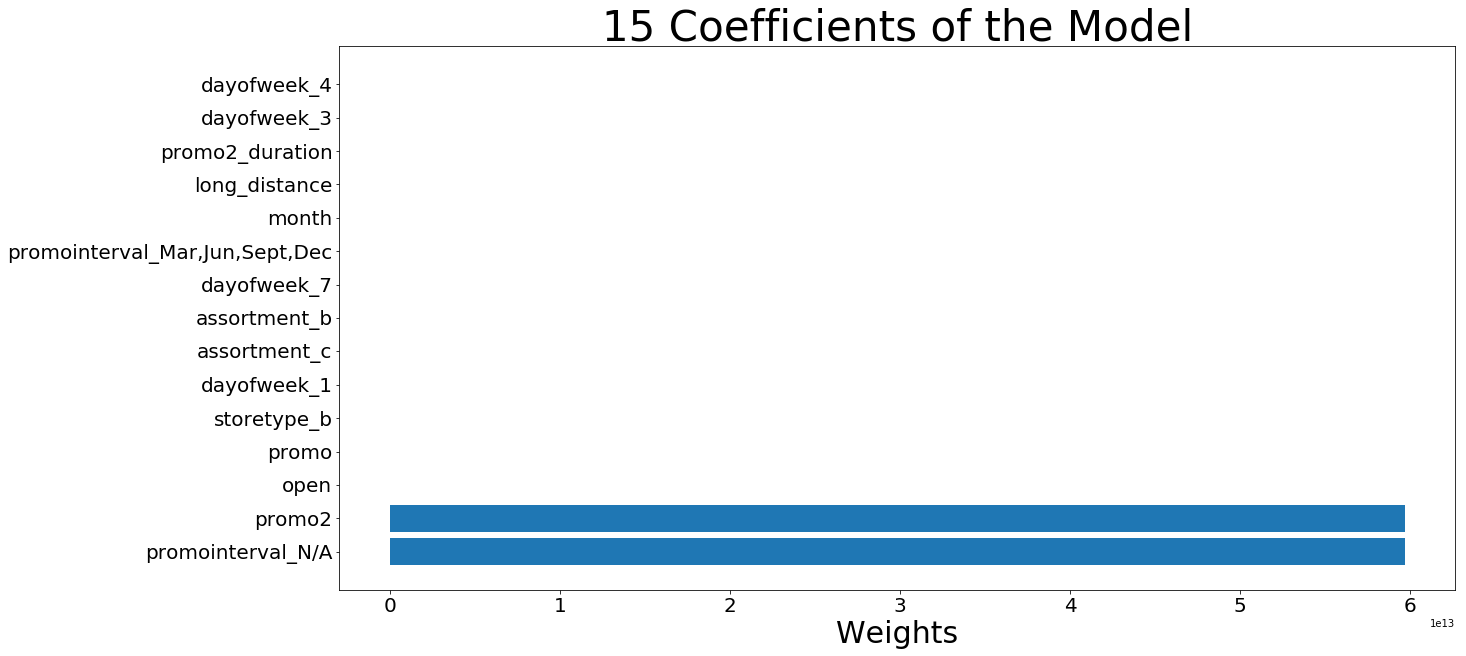

In [173]:
plt.figure(figsize=(20,10))
plt.barh(weights.index, weights)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel('Weights', fontsize=30)
plt.title('15 Coefficients of the Model', fontsize=42)
plt.savefig('../images/betas');

The intercept of my model is 5806.8, which is closer to the mean of sales of the dataset. Based on my model, the features promointerval N/A and promo2 have a huge impact on sales.

### Random Forest

In [149]:
rf= RandomForestRegressor()

##### Grid Search

In order to find the best parameters and performance, we can use grid search.

In [150]:
pipe = Pipeline([
    ('rf',RandomForestRegressor(n_jobs= -1,
                                random_state=42,
                                criterion= 'mse'))])

In [151]:
param_grid =  {
    'rf__min_samples_leaf': [6, 10],
    'rf__min_samples_split':[2, 4],
    'rf__n_estimators':[150, 200]
}


In [152]:
gs_rf = GridSearchCV(pipe, param_grid)

In [153]:
gs_rf.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('rf', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
           oob_score=False, random_state=42, verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'rf__min_samples_leaf': [6, 10], 'rf__min_samples_split': [2, 4], 'rf__n_estimators': [150, 200]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [154]:
gs_rf.best_params_

{'rf__min_samples_leaf': 10,
 'rf__min_samples_split': 2,
 'rf__n_estimators': 200}

In [168]:
gs_rf.score(X_test, y_test)

0.050388210100251074

In [169]:
gs_rf.score(X_train, y_train)

0.9360855843708316

In [171]:
np.sqrt(mean_squared_error(y_test, gs_rf.predict(X_test)))

3607.7686832461522

### Feature importance

In [155]:
feat= pd.DataFrame(gs_rf.best_estimator_.named_steps['rf'].feature_importances_, 
                   X_train.columns, 
                   columns=['importance'])

In [156]:
new_feat= feat.sort_values(ascending= False, by= 'importance')[:7]

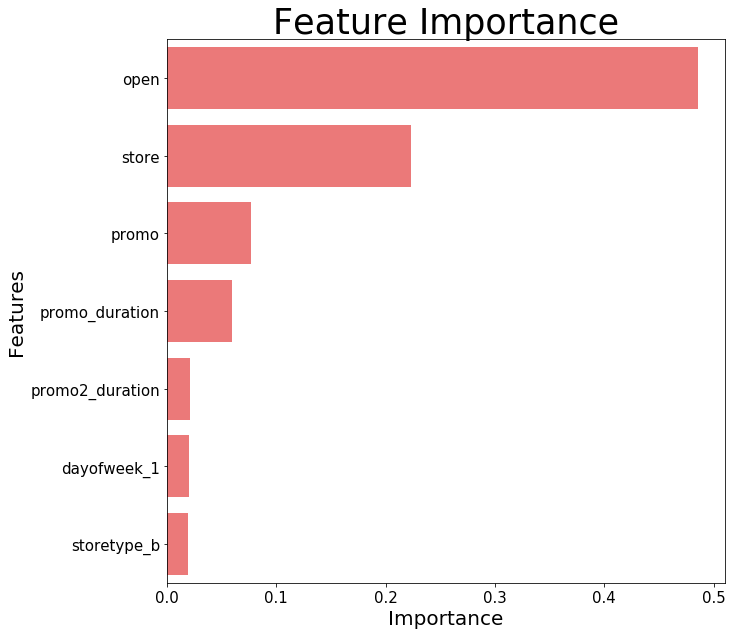

In [174]:
plt.figure(figsize=(10,10))
fig = sns.barplot(x= 'importance', 
            y= new_feat.index, 
            data= new_feat, 
            color='r',
            alpha= 0.6)
plt.title('Feature Importance', fontsize= 35)
plt.xlabel('Importance', fontsize= 20)
plt.xticks(size= 15)
plt.ylabel("Features", fontsize=20)
plt.yticks(size= 15)
plt.savefig('../images/feature');

Based on my model, these are 7 important features that affect the sales price. We do not know how much weight each features will have, but it can be informative.

##### Export the model

In [170]:
with open('../assets/gs_rf.pkl','wb+') as f:
     pickle.dump(gs_rf,f)